## Projet Machine Learning pour la finance : étude de la méthode LSM au cas d'un Put American

In [92]:
## Importation des données

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from numpy.polynomial.polynomial import polyval
import time

## Méthode binomiale par Cox, Ross et Rubinstein (CRR)

In [93]:
#définition des fonctions de payoff
def put_payoff(S,K):
    if (K-S)>0:
        return K-S
    else:
        return 0

def call_payoff(S,K):
    if (S-K)>0:
        return S-K
    else:
        return 0

In [94]:
def CRR_american(S,K,T,r,sigma,N):
    pas = T/N
    u = np.exp(sigma*np.sqrt(pas))
    d = 1/u
    p = (np.exp(r*pas)-d)/(u-d)
    #filling the tree( no need to create a matrix a vector of vectors is enough)
    tree = [[S]]
    for i in range(1, N):
        x = (i+1) * [0]
        for j in range(len(x)):
            x[j] = S * (d**j) * u**(i - j)
        tree = tree + [x]
    
    #Payoff @ maturity
    n = len(tree)
    for i in range (0, len(tree[n-1])):
        tree[n-1][i] = put_payoff(tree[n-1][i],K)
    
    #Backward pricing
    for j in range(n - 1, 0, -1):
        V = tree[j] 
        for i in range(len(V) - 1):
            Vtemp = np.exp(-r*pas) * (p*V[i] + (1-p)*V[i+1])
            tree[j-1][i] = max(Vtemp, K - tree[j-1][i])
        
    return tree[0][0]


## Méthode de Monte Carlo avec des régressions linéaires: Longstaff-Schwartz methode 

In [95]:
def LSM_american(S0,K,T,r,sigma, N,M):
    pasT=T/M
    S=np.zeros((N,M))
    S[:,0]=S0
    B=np.zeros((N,1))
    P=np.zeros((N,M))
    
    #Initialization at maturity
    for i in range(N):
        B[i] = np.sqrt(T) * np.random.normal(0,1)
        S[i, -1] = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * B[i]) ## ajouter le poisson
        P[i, -1] = max(K - S[i, -1], 0)
        P[i, -2] = np.exp(-r * pasT) * P[i, -1]
        
    #Backward loop of LSM Method 
    for j in range(M - 2, 0, -1):
        for i in range(N):
            B[i] = np.random.normal((j * B[i]) / (j + 1),
                                           np.sqrt((j * pasT) / (j + 1)))
            S[i,j]= S0 * np.exp((r  -0.5 * sigma ** 2) * (j + 1) * pasT + sigma * B[i]) ## ajouter le poisson
        
        
    # rien ne change après ça    
        ITM = S[:, j] < K
        if np.sum(ITM) != 0 :
            alphas = np.polyfit(S[ITM,j], P[ITM,j+1], 2)
            #poly = PolynomialFeatures(degree=2)
            #X_poly = poly.fit_transform(S[ITM,j])
            #model = LinearRegression().fit(X_poly, P[ITM,j+1])
            #y = model.predict()
            for i in range(N):
                if ITM[i] and max(K - S[i,j], 0) > polyval(S[i,j],
                                                           alphas,tensor=False):
                    P[i, j + 1] = max(K - S[i, j],0)
        for i in range(N):
            P[i, j] = np.exp(-r * pasT) * P[i, j + 1]
            
    #Discount prices on all paths
    for i in range(N):
        P[i, 0] = np.exp(-r * pasT) * P[i, 1]
    
    #Option price is:     
    return max(put_payoff(S0,K),np.mean(P[:, 0]))


## Visualisation des résultats et comparaison des deux méthodes

In [96]:
#Initialisation des variables
S = 100
K = 100
T = 1
r = 0.05
sigma = 0.2


/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly cond

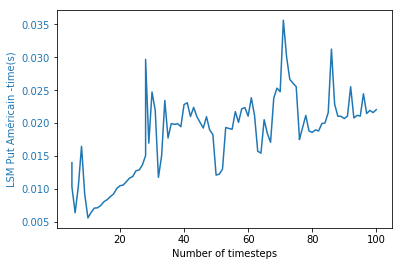

In [97]:
n = np.linspace(5,100, 100,dtype=int)
time_list_A = []
time_list_B = []

for x in n:
    start = time.time()
    LSM_american(S,K,T,r,sigma,x, 12)
    end = time.time() - start
    time_list_B.append(end)

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Number of timesteps')
ax1.set_ylabel('LSM Put Américain -time(s)', color=color)
ax1.plot(n, time_list_B, color=color)
ax1.tick_params(axis='y', labelcolor=color)



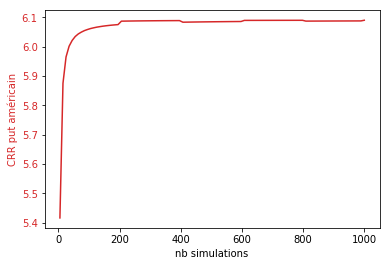

In [98]:
n = np.linspace(5,1000, 100,dtype=int)
x1 = [CRR_american(S,K,T,r,sigma,x) for x in n]

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('nb simulations')
ax1.set_ylabel('CRR put américain', color=color)
ax1.plot(n, x1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

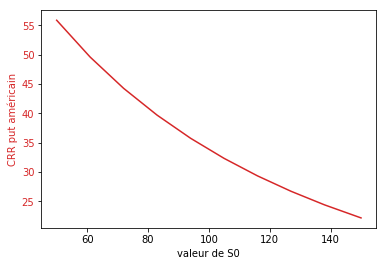

In [109]:
n = np.linspace(50,150, 10,dtype=int)
x1 = [CRR_american(x,K,T,r,sigma,5000) for x in n]

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('valeur de S0')
ax1.set_ylabel('CRR put américain', color=color)
ax1.plot(n, x1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

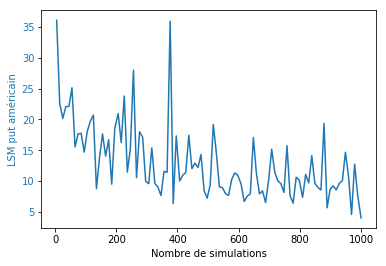

In [108]:
n = np.linspace(5,1000, 100,dtype=int)
x2 = [LSM_american(S,K,T,r,sigma,100,x) for x in n]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Nombre de simulations')
ax1.set_ylabel('LSM put américain', color=color)
ax1.plot(n, x2, color=color)
ax1.tick_params(axis='y', labelcolor=color)

/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly cond

/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly cond

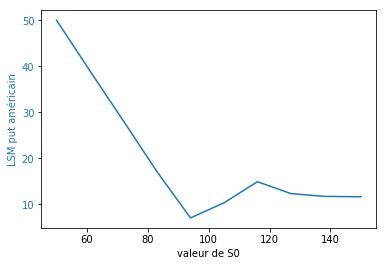

In [110]:
n = np.linspace(50,150, 10,dtype=int)
x2 = [LSM_american(x,K,T,r,sigma,100,5000) for x in n]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('valeur de S0')
ax1.set_ylabel('LSM put américain', color=color)
ax1.plot(n, x2, color=color)
ax1.tick_params(axis='y', labelcolor=color)

## Méthode de Monte Carlo avec des régressions linéaires: Longstaff-Schwartz methode
## Cas d'un processus à saut 

In [101]:
def LSM_jump_american(S0,K,T,r,sigma, N,M,lambda_jump):
    pasT=T/M
    S=np.zeros((N,M))
    S[:,0]=S0
    B=np.zeros((N,1))
    
    U=np.zeros((N,1))
    
    P=np.zeros((N,M)) 
    
    #Initialization at maturity
    for i in range(N):
        B[i] = np.sqrt(T) * np.random.normal(0,1)
        U[i] = np.random.uniform(0, T, 1)*(np.random.poisson(lambda_jump*T)>0)
        if(U[i] != 0):
            S[i, -1] = 0
        else :
            S[i, -1] = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * B[i]) ## ajouter le poisson
            
        P[i, -1] = max(K - S[i, -1], 0)
        P[i, -2] = np.exp(-r * pasT) * P[i, -1]
        
    #Backward loop of LSM Method 
    for j in range(M - 2, 0, -1):
        for i in range(N):
            B[i] = np.random.normal((j * B[i]) / (j + 1),
                                           np.sqrt((j * pasT) / (j + 1)))
            if(U[i] < (j + 1) * pasT and U[i]!=0):
                S[i,j] = 0
            else :
                S[i,j]= S0 * np.exp((r  -0.5 * sigma ** 2) * (j + 1) * pasT + sigma * B[i]) ## ajouter le poisson
        
        
    # rien ne change après ça    
        ITM = S[:, j] < K
        if np.sum(ITM) != 0 :
            alphas = np.polyfit(S[ITM,j], P[ITM,j+1], 1)
            #poly = PolynomialFeatures(degree=2)
            #X_poly = poly.fit_transform(S[ITM,j])
            #model = LinearRegression().fit(X_poly, P[ITM,j+1])
            #y = model.predict()
            for i in range(N):
                if ITM[i] and max(K - S[i,j], 0) > polyval(S[i,j],
                                                           alphas,tensor=False):
                    P[i, j + 1] = max(K - S[i, j],0)
        for i in range(N):
            P[i, j] = np.exp(-r * pasT) * P[i, j + 1]
            
    #Discount prices on all paths
    for i in range(N):
        P[i, 0] = np.exp(-r * pasT) * P[i, 1]
    
    #Option price is:     
    return max(put_payoff(S0,K),np.mean(P[:, 0]))


In [102]:
#Initialisation
S = 100
K = 100
T = 1
r = 0.05
sigma = np.sqrt(0.9)
lambda_jump = 0.05

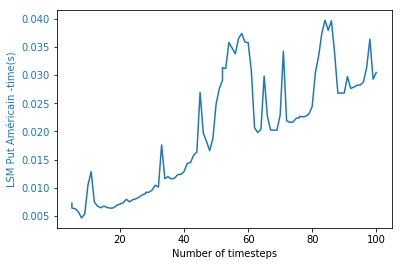

In [103]:
n = np.linspace(5,100, 100,dtype=int)
time_list_A = []
time_list_B = []

for x in n:
    start = time.time()
    LSM_jump_american(S,K,T,r,sigma,x, 12,lambda_jump)
    end = time.time() - start
    time_list_B.append(end)

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Number of timesteps')
ax1.set_ylabel('LSM Put Américain -time(s)', color=color)
ax1.plot(n, time_list_B, color=color)
ax1.tick_params(axis='y', labelcolor=color)


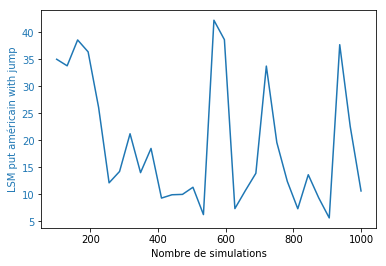

In [111]:
n = np.linspace(100,1000, 30,dtype=int)
x2 = [LSM_jump_american(S,K,T,r,sigma,100,x,lambda_jump) for x in n]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Nombre de simulations')
ax1.set_ylabel('LSM put américain with jump', color=color)
ax1.plot(n, x2, color=color)
ax1.tick_params(axis='y', labelcolor=color)

/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RankWarning: Polyfit may be poorly conditioned
/Users/guilluy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RankWarning: Polyfit may be poorly cond

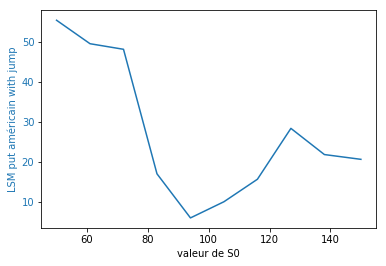

In [107]:
n = np.linspace(50,150, 10,dtype=int)
x2 = [LSM_jump_american(x,K,T,r,sigma,100,5000,lambda_jump) for x in n]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('valeur de S0')
ax1.set_ylabel('LSM put américain with jump', color=color)
ax1.plot(n, x2, color=color)
ax1.tick_params(axis='y', labelcolor=color)